In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from dataclasses import dataclass
from typing import Tuple, Dict
import math
from pathlib import Path

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 30)


Anteprima Retail (prime 10 righe)


C:\Users\admloc\AppData\Local\Temp\ipykernel_7852\388004340.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  out = out.set_index("date").resample("M").last().dropna().reset_index()
C:\Users\admloc\AppData\Local\Temp\ipykernel_7852\388004340.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  out = out.set_index("date").resample("M").last().dropna().reset_index()


,date,volume
0,2003-01-31,318147.0
1,2003-02-28,323421.0
2,2003-03-31,326768.0
3,2003-04-30,331440.0
4,2003-05-31,329231.0
5,2003-06-30,335415.0
6,2003-07-31,334661.0
7,2003-08-31,329397.0
8,2003-09-30,334053.0
9,2003-10-31,335703.0



Anteprima Corporate (prime 10 righe)


,date,volume
0,2003-01-31,96065.0
1,2003-02-28,94946.0
2,2003-03-31,98017.0
3,2003-04-30,102425.0
4,2003-05-31,104693.0
5,2003-06-30,105451.0
6,2003-07-31,103573.0
7,2003-08-31,106073.0
8,2003-09-30,106850.0
9,2003-10-31,110454.0



Sintesi descrittiva iniziale (Retail & Corporate)


,serie,periodo_inizio,periodo_fine,osservazioni_mensili,media_volume,mediana_volume,min_volume,max_volume,freq_mensile_%_stimata
0,RETAIL,2003-01-31,2025-08-31,272,594486.507353,515440.5,318147.0,951914.0,100.0
1,CORPORATE,2003-01-31,2025-08-31,272,221810.889706,176685.5,94946.0,421143.0,100.0


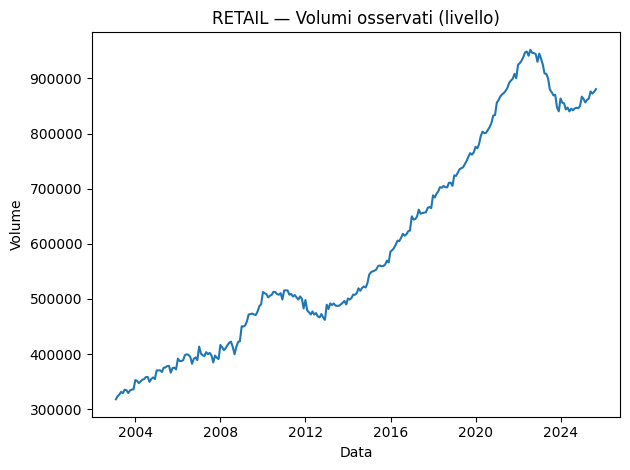

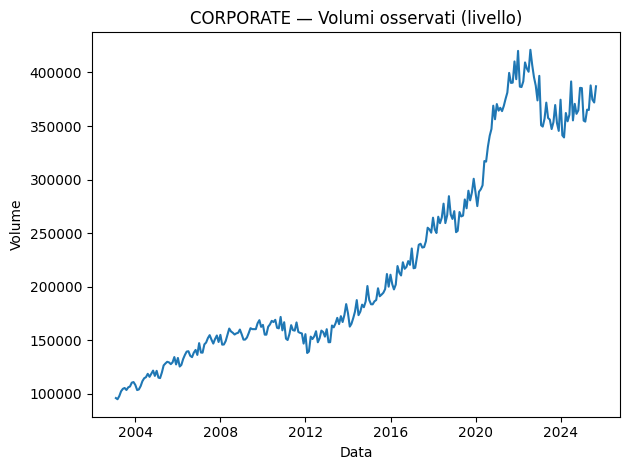

In [79]:
# Step 1: Caricamento e visualizzazione dei dati di partenza (Retail e Corporate)

def load_series(csv_path: str) -> pd.DataFrame:
    """
    Carica un CSV e prova a riconoscere automaticamente la colonna data e quella dei volumi.
    Restituisce un DataFrame con colonne: ['date', 'volume'] (mensile, ordinata, senza NA).
    """
    df = pd.read_csv(csv_path)


    # Il volume è sempre la terza colonna
    if df.shape[1] < 3:
        raise ValueError(f"Il file {csv_path} non contiene almeno 3 colonne; impossibile prendere la terza come volume.")
    vol_col = df.columns[2]
    
    date_col="DATE"

    out = df[[date_col, vol_col]].copy()
    out.columns = ["date","volume"]
    out["date"] = pd.to_datetime(out["date"])
    out = out.sort_values("date").dropna()
    out = out[out["volume"] > 0]

    # Normalizza a frequenza mensile (saldo di fine mese)
    out = out.set_index("date").resample("M").last().dropna().reset_index()
    return out

def describe_series(df: pd.DataFrame, name: str) -> pd.DataFrame:
    start = df["date"].min()
    end = df["date"].max()
    months = df.shape[0]
    gaps = df["date"].diff().dt.days.dropna()
    approx_month = ((gaps >= 28) & (gaps <= 31)).mean() * 100.0 if len(gaps) else np.nan
    stats = {
        "serie": [name],
        "periodo_inizio": [start],
        "periodo_fine": [end],
        "osservazioni_mensili": [months],
        "media_volume": [df["volume"].mean()],
        "mediana_volume": [df["volume"].median()],
        "min_volume": [df["volume"].min()],
        "max_volume": [df["volume"].max()],
        "freq_mensile_%_stimata": [approx_month]
    }
    return pd.DataFrame(stats)

def plot_series(df: pd.DataFrame, title: str):
    plt.figure()
    plt.plot(df["date"], df["volume"])
    plt.title(title)
    plt.xlabel("Data")
    plt.ylabel("Volume")
    plt.tight_layout()
    plt.show()

# --- Caricamento dati ---

# Percorsi relativi rispetto alla posizione del notebook
RETAIL_PATH = Path("Retail CSV.csv")
CORPORATE_PATH = Path("Corporate CSV.csv") 

# Caricamento dati con percorsi relativi
retail_df = load_series(RETAIL_PATH)
corporate_df = load_series(CORPORATE_PATH)

# --- Anteprime ---
print("\nAnteprima Retail (prime 10 righe)")
display(retail_df.head(10))
print("\nAnteprima Corporate (prime 10 righe)")
display(corporate_df.head(10))

# --- Descrittive ---
summary_df = pd.concat([
    describe_series(retail_df, "RETAIL"),
    describe_series(corporate_df, "CORPORATE")
], ignore_index=True)
print("\nSintesi descrittiva iniziale (Retail & Corporate)")
display(summary_df)

# --- Grafici ---
plot_series(retail_df, "RETAIL — Volumi osservati (livello)")
plot_series(corporate_df, "CORPORATE — Volumi osservati (livello)")


Media geometrica — Retail: 564159.01
Media geometrica — Corporate: 203310.84

Retail — prime 12 righe con v_log e y_t


,date,volume,v_log,y_t
0,2003-01-31,318147.0,12.670269,-0.572823
1,2003-02-28,323421.0,12.686710,-0.556381
2,2003-03-31,326768.0,12.697006,-0.546086
3,2003-04-30,331440.0,12.711202,-0.531889
4,2003-05-31,329231.0,12.704515,-0.538577
5,2003-06-30,335415.0,12.723124,-0.519968
6,2003-07-31,334661.0,12.720873,-0.522218
7,2003-08-31,329397.0,12.705019,-0.538072
8,2003-09-30,334053.0,12.719055,-0.524036
9,2003-10-31,335703.0,12.723982,-0.519109



Corporate — prime 12 righe con v_log e y_t


,date,volume,v_log,y_t
0,2003-01-31,96065.0,11.472780,-0.749711
1,2003-02-28,94946.0,11.461064,-0.761428
2,2003-03-31,98017.0,11.492896,-0.729595
3,2003-04-30,102425.0,11.536886,-0.685605
4,2003-05-31,104693.0,11.558788,-0.663704
5,2003-06-30,105451.0,11.566002,-0.656490
6,2003-07-31,103573.0,11.548032,-0.674459
7,2003-08-31,106073.0,11.571883,-0.650608
8,2003-09-30,106850.0,11.579181,-0.643310
9,2003-10-31,110454.0,11.612354,-0.610137


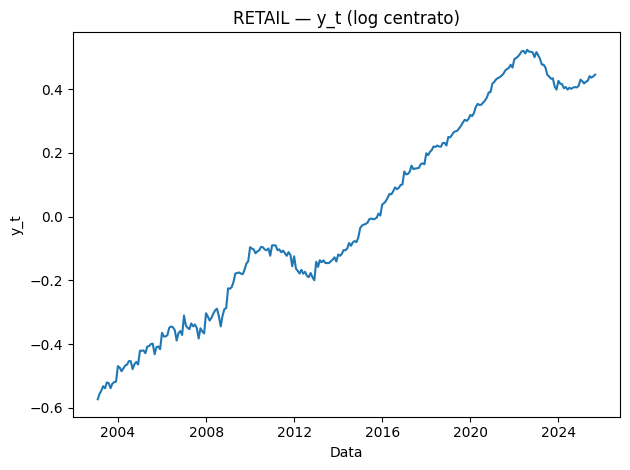

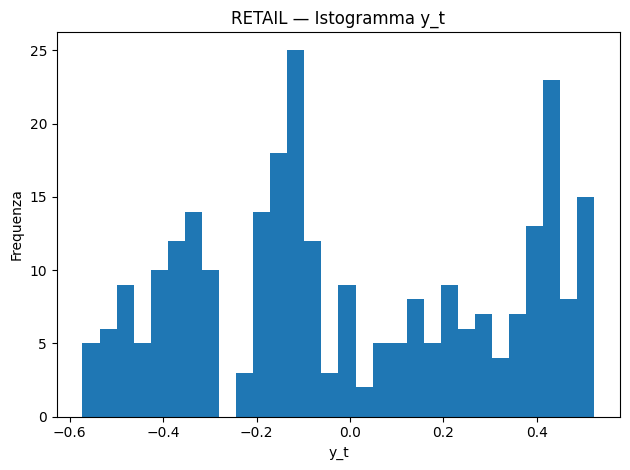

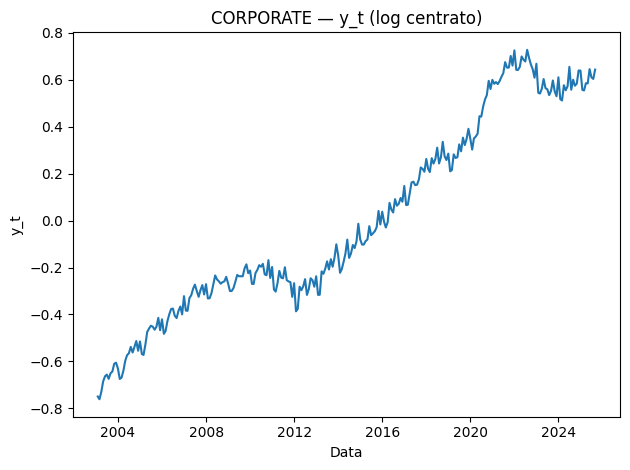

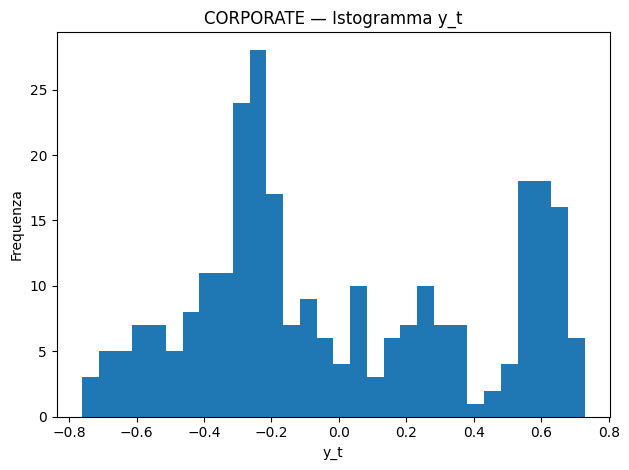

In [80]:
def build_log_centered(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggiunge v_log = log(volume) e y_t = v_log - mean(v_log).
    Salva in df.attrs:
      - 'vbar' = media di v_log
      - 'geom_mean_level' = exp(vbar)
    """
    out = df.copy()
    out["v_log"] = np.log(out["volume"].astype(float))
    vbar = out["v_log"].mean()
    out["y_t"] = out["v_log"] - vbar
    out.attrs["vbar"] = float(vbar)
    out.attrs["geom_mean_level"] = float(np.exp(vbar))
    return out


# --- Trasformazione e centratura ---
retail_step2 = build_log_centered(retail_df)
corporate_step2 = build_log_centered(corporate_df)


# --- Riepilogo: media geometrica ---
print("Media geometrica — Retail:", f"{retail_step2.attrs['geom_mean_level']:.2f}")
print("Media geometrica — Corporate:", f"{corporate_step2.attrs['geom_mean_level']:.2f}")

# --- Ispezione delle nuove colonne ---
print("\nRetail — prime 12 righe con v_log e y_t")
display(retail_step2.head(12))
print("\nCorporate — prime 12 righe con v_log e y_t")
display(corporate_step2.head(12))

# --- Grafici diagnostici: y_t nel tempo e istogramma ---
def plot_centered_series(df_centered: pd.DataFrame, title_prefix: str):
    # y_t nel tempo
    plt.figure()
    plt.plot(df_centered["date"], df_centered["y_t"])
    plt.title(f"{title_prefix} — y_t (log centrato)")
    plt.xlabel("Data"); plt.ylabel("y_t")
    plt.tight_layout(); plt.show()

    # istogramma di y_t
    plt.figure()
    plt.hist(df_centered["y_t"].dropna(), bins=30)
    plt.title(f"{title_prefix} — Istogramma y_t")
    plt.xlabel("y_t"); plt.ylabel("Frequenza")
    plt.tight_layout(); plt.show()

plot_centered_series(retail_step2, "RETAIL")
plot_centered_series(corporate_step2, "CORPORATE")

Iter   1 — beta=0.985299, Q=2.876813e-03, R=8.900825e-03, rel_change=7.713e-02
Iter   2 — beta=0.987906, Q=2.154078e-03, R=2.571475e-03, rel_change=6.986e-03
Iter   3 — beta=0.991348, Q=1.354412e-03, R=1.124366e-03, rel_change=3.865e-03
Iter  20 — beta=0.996542, Q=2.413943e-04, R=1.839421e-05, rel_change=2.209e-06
Iter  40 — beta=0.996528, Q=2.446250e-04, R=7.569697e-06, rel_change=3.878e-07
Iter  60 — beta=0.996524, Q=2.455147e-04, R=4.739860e-06, rel_change=1.538e-07
Iter  73 — beta=0.996523, Q=2.458116e-04, R=3.809906e-06, rel_change=9.976e-08

RETAIL — Parametri stimati:
  beta (AR1)    = 0.996523
  Q (state var) = 2.458116e-04
  R (meas var)  = 3.809906e-06
  theta (OU)    = 0.041795  (se definito per beta>0)


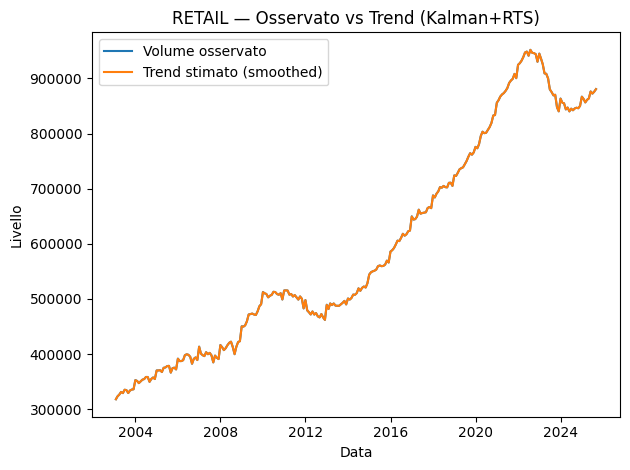

Iter   1 — beta=0.985438, Q=4.720927e-03, R=1.528576e-02, rel_change=1.151e-01
Iter   2 — beta=0.987708, Q=3.730272e-03, R=4.655237e-03, rel_change=1.107e-02
Iter   3 — beta=0.990407, Q=2.701868e-03, R=2.175340e-03, rel_change=3.854e-03
Iter  20 — beta=0.993658, Q=1.596089e-03, R=1.031627e-04, rel_change=1.277e-05
Iter  40 — beta=0.993573, Q=1.630178e-03, R=4.668685e-05, rel_change=2.505e-06
Iter  60 — beta=0.993548, Q=1.640121e-03, R=3.009640e-05, rel_change=1.031e-06
Iter  80 — beta=0.993537, Q=1.644857e-03, R=2.219015e-05, rel_change=5.585e-07
Iter 100 — beta=0.993530, Q=1.647626e-03, R=1.756848e-05, rel_change=3.493e-07
Iter 120 — beta=0.993525, Q=1.649441e-03, R=1.453794e-05, rel_change=2.389e-07
Iter 140 — beta=0.993522, Q=1.650723e-03, R=1.239804e-05, rel_change=1.735e-07
Iter 160 — beta=0.993520, Q=1.651677e-03, R=1.080667e-05, rel_change=1.318e-07
Iter 180 — beta=0.993518, Q=1.652414e-03, R=9.577002e-06, rel_change=1.034e-07
Iter 183 — beta=0.993518, Q=1.652510e-03, R=9.416259

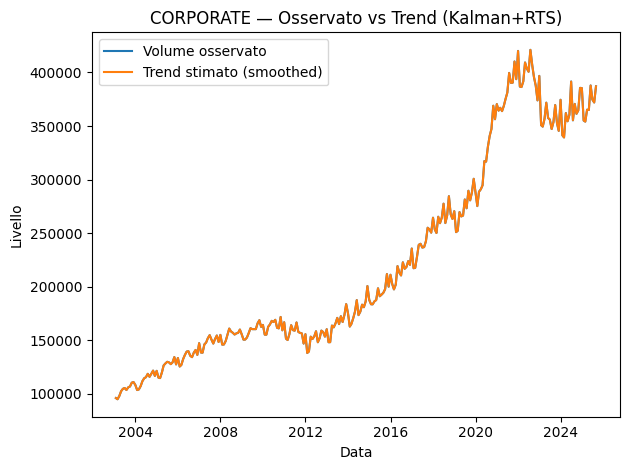

In [81]:
# --- Modello in spazio degli stati: definizioni ---

@dataclass
class SSMParams:
    beta: float   # coefficiente AR(1) nello stato
    Q: float      # varianza del rumore di stato
    R: float      # varianza del rumore di misura

@dataclass
class SSMResults:
    params: SSMParams
    xs: np.ndarray      # E[s_t | Y_1:T] (smoothed states)
    Ps: np.ndarray      # Var(s_t | Y_1:T)
    Pcs: np.ndarray     # Cov(s_t, s_{t-1} | Y_1:T)

def kalman_filter(y: np.ndarray, params: SSMParams):
    T = len(y)
    beta, Q, R = params.beta, params.Q, params.R
    x_pred = np.zeros(T); P_pred = np.zeros(T)
    x_filt = np.zeros(T); P_filt = np.zeros(T)

    # inizializzazione stazionaria dell'AR(1)
    x0 = 0.0
    P0 = Q / (1 - beta**2 + 1e-12)
    xp, Pp = x0, P0

    for t in range(T):
        # update
        S = Pp + R
        K = Pp / (S + 1e-12)
        xf = xp + K * (y[t] - xp)
        Pf = (1 - K) * Pp

        x_filt[t] = xf; P_filt[t] = Pf

        # predict
        xp = beta * xf
        Pp = beta**2 * Pf + Q
        x_pred[t] = xp; P_pred[t] = Pp

    return x_pred, P_pred, x_filt, P_filt

def rts_smoother(y: np.ndarray, params: SSMParams, x_pred, P_pred, x_filt, P_filt):
    T = len(y)
    beta = params.beta
    xs = np.copy(x_filt); Ps = np.copy(P_filt)
    Pcs = np.zeros(T)  # Cov(s_t, s_{t-1})

    for t in range(T-2, -1, -1):
        C = P_filt[t] * beta / (P_pred[t+1] + 1e-12)
        xs[t] = x_filt[t] + C * (xs[t+1] - x_pred[t+1])
        Ps[t] = P_filt[t] + C**2 * (Ps[t+1] - P_pred[t+1])
        Pcs[t+1] = C * Ps[t+1]  # stima standard

    return xs, Ps, Pcs

def em_step(y: np.ndarray, params: SSMParams):
    x_pred, P_pred, x_filt, P_filt = kalman_filter(y, params)
    xs, Ps, Pcs = rts_smoother(y, params, x_pred, P_pred, x_filt, P_filt)
    T = len(y)

    Exx = Ps + xs**2
    Exx_prev = Exx[:-1]
    Exx_curr = Exx[1:]
    Exx1 = Pcs[1:] + xs[1:] * xs[:-1]

    beta_new = (Exx1.sum()) / (Exx_prev.sum() + 1e-12)
    Q_new = (Exx_curr.sum() - 2*beta_new*Exx1.sum() + (beta_new**2)*Exx_prev.sum()) / (T-1 + 1e-12)
    R_new = ((y**2).sum() - 2*(y*xs).sum() + Exx.sum()) / (T + 1e-12)

    beta_new = float(np.clip(beta_new, -0.999, 0.999))
    Q_new = float(max(Q_new, 1e-12))
    R_new = float(max(R_new, 1e-12))

    return SSMParams(beta_new, Q_new, R_new), (xs, Ps, Pcs)

def em_fit(y: np.ndarray, max_iter: int = 300, tol: float = 1e-7, verbose: bool = True) -> SSMResults:
    y = np.asarray(y, dtype=float)
    y = y - np.mean(y)  # sicurezza numerica

    var_y = float(np.var(y))
    params = SSMParams(beta=0.95, Q=0.3*var_y*(1-0.95**2 + 1e-12), R=0.7*var_y)

    last = np.array([params.beta, params.Q, params.R], dtype=float)
    xs = Ps = Pcs = None
    for it in range(1, max_iter+1):
        params, eout = em_step(y, params)
        xs, Ps, Pcs = eout
        cur = np.array([params.beta, params.Q, params.R], dtype=float)
        rel = np.linalg.norm(cur - last) / (np.linalg.norm(last) + 1e-12)
        if verbose and (it <= 3 or it % 20 == 0 or rel < tol):
            print(f"Iter {it:3d} — beta={params.beta:.6f}, Q={params.Q:.6e}, R={params.R:.6e}, rel_change={rel:.3e}")
        if rel < tol:
            break
        last = cur
    return SSMResults(params=params, xs=xs, Ps=Ps, Pcs=Pcs)

def ou_from_ar1(beta: float, Q: float, delta: float = 1/12) -> Dict[str, float]:
    """
    Parametri OU equivalenti (tempo continuo) — utile per interpretazione:
      theta = -ln(beta)/Δ , sigma_s^2 = Q * 2*theta / (1 - exp(-2*theta*Δ))
    Valido per beta>0.
    """
    beta = float(np.clip(beta, -0.999, 0.999))
    if beta <= 0:
        return {"theta": np.nan, "sigma_s": np.nan}
    theta = -math.log(max(beta, 1e-9)) / delta
    sigma_s_sq = Q * (2*theta) / (1 - math.exp(-2*theta*delta) + 1e-12)
    return {"theta": theta, "sigma_s": math.sqrt(max(sigma_s_sq, 0.0))}

# --- Funzione helper per stimare e graficare una serie ---
def estimate_and_plot(df_centered: pd.DataFrame, name: str):
    y = df_centered["y_t"].values.astype(float)
    vbar = df_centered.attrs["vbar"]

    res = em_fit(y, max_iter=300, tol=1e-7, verbose=True)
    ou = ou_from_ar1(res.params.beta, res.params.Q, delta=1/12)

    print(f"\n{name} — Parametri stimati:")
    print(f"  beta (AR1)    = {res.params.beta:.6f}")
    print(f"  Q (state var) = {res.params.Q:.6e}")
    print(f"  R (meas var)  = {res.params.R:.6e}")
    print(f"  theta (OU)    = {ou['theta']:.6f}  (se definito per beta>0)")

    # Trend stimato in livello: exp(vbar + xs)
    trend_level = np.exp(vbar + res.xs)

    df_plot = df_centered[["date","volume"]].copy()
    df_plot["trend_level"] = trend_level

    # Grafico: osservato vs trend stimato
    plt.figure()
    plt.plot(df_plot["date"], df_plot["volume"], label="Volume osservato")
    plt.plot(df_plot["date"], df_plot["trend_level"], label="Trend stimato (smoothed)")
    plt.title(f"{name} — Osservato vs Trend (Kalman+RTS)")
    plt.xlabel("Data"); plt.ylabel("Livello"); plt.legend()
    plt.tight_layout(); plt.show()

    return res, ou, df_plot

# --- Stima per Retail e Corporate ---
retail_res, retail_ou, retail_plotdf = estimate_and_plot(retail_step2, "RETAIL")
corporate_res, corporate_ou, corporate_plotdf = estimate_and_plot(corporate_step2, "CORPORATE")


=== RETAIL — significance 90% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,880628.0,878334.592031,0.002604,0.9,0.996523,0.000246


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,mpa_livello
0,1,0.021344,0.021344,0.000032,0.021376,859538.625057
2,3,0.020301,0.062460,0.000032,0.020334,823330.295151
11,12,0.016265,0.224246,0.000032,0.016297,680857.051572
23,24,0.012213,0.391794,0.000032,0.012246,533309.548307
35,36,0.009263,0.518267,0.000032,0.009296,421934.384364
47,48,0.007094,0.614675,0.000032,0.007126,337034.901205


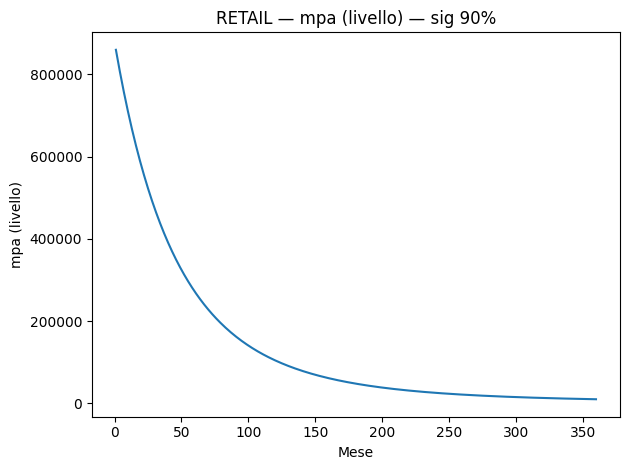


=== RETAIL — significance 95% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,880628.0,877712.009471,0.003311,0.95,0.996523,0.000246


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,mpa_livello
0,1,0.026866,0.026866,0.00001,0.026876,854052.927086
2,3,0.025266,0.078184,0.00001,0.025276,808861.035371
11,12,0.019253,0.274178,0.00001,0.019263,636263.335902
23,24,0.013555,0.465990,0.00001,0.013565,467348.503437
35,36,0.009666,0.601925,0.00001,0.009676,347640.054666
47,48,0.006976,0.699463,0.00001,0.006986,261745.506683


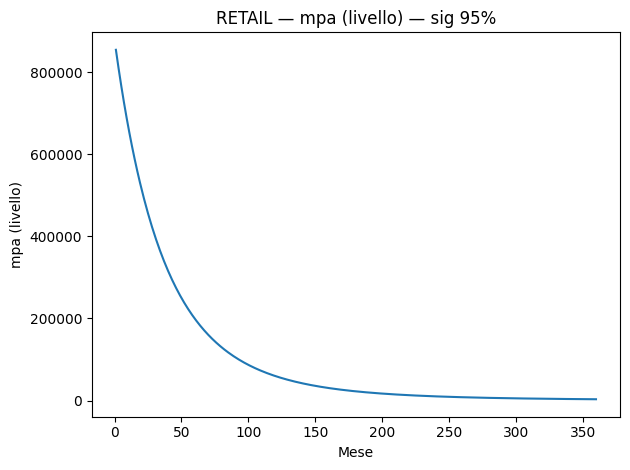


=== CORPORATE — significance 90% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,387071.0,385456.338357,0.004171,0.9,0.993518,0.001653


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,mpa_livello
0,1,0.054462,0.054462,0.000001,0.054464,364375.509224
2,3,0.048074,0.153696,0.000001,0.048075,325965.111831
11,12,0.027907,0.476670,0.000001,0.027909,200951.077143
23,24,0.014103,0.711611,0.000001,0.014104,110012.442886
35,36,0.007458,0.833032,0.000001,0.007459,63013.757772
47,48,0.004113,0.898597,0.000001,0.004114,37635.397466


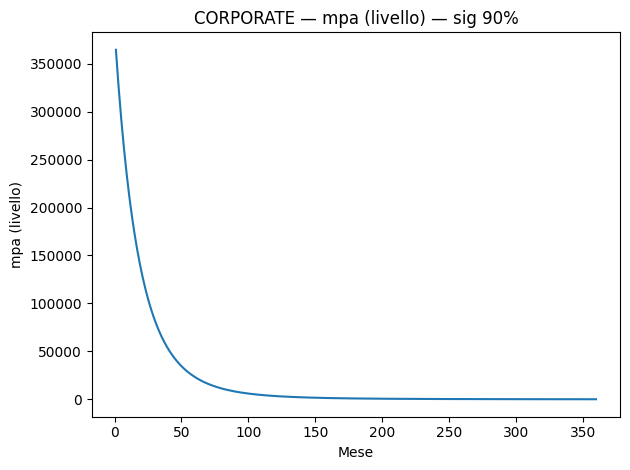


=== CORPORATE — significance 95% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,387071.0,385026.87641,0.005281,0.95,0.993518,0.001653


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,mpa_livello
0,1,0.068180,0.068180,1.386354e-07,0.068180,358636.296488
2,3,0.058443,0.189733,1.386354e-07,0.058443,311586.758202
11,12,0.029869,0.557630,1.386354e-07,0.029869,169184.633339
23,24,0.012880,0.790428,1.386354e-07,0.012880,79075.280365
35,36,0.005882,0.893625,1.386354e-07,0.005882,39130.724183
47,48,0.002832,0.941979,1.386354e-07,0.002832,20414.126463


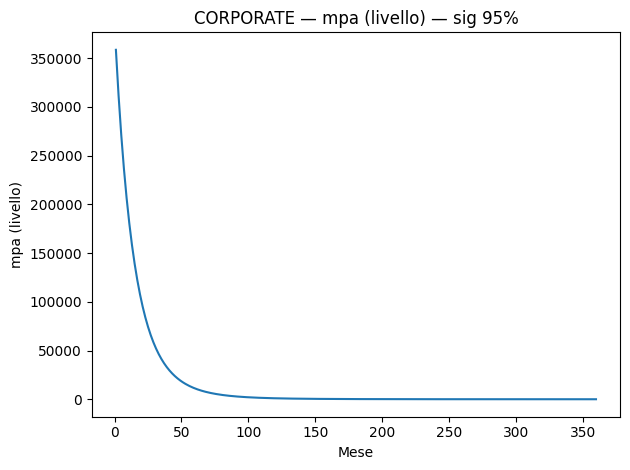

In [82]:
def stable_volatile_and_mpa(v_log: np.ndarray,
                            xs: np.ndarray,
                            Ps: np.ndarray,
                            beta: float,
                            Q: float,
                            horizons: int = 360,
                            significance: float = 0.99):
    """
    Calcola:
      - stable_T (livello) e quota volatile l_T
      - profilo mpa su 'horizons' mesi
      - ammortamenti mensili in % del volume corrente VT
    Ritorna (summary_df, schedule_df).
    """
    assert 0.5 < significance < 1.0, "significance deve essere in (0.5,1)."
    q = norm.ppf(1 - significance)  # < 0
    vbar = float(np.mean(v_log))
    VT = float(np.exp(v_log[-1]))

    piT = float(xs[-1])
    deltaT = float(np.sqrt(Ps[-1]))
    s_lb = piT + deltaT * q

    stable_T = float(np.exp(vbar + s_lb))
    l_T = float(1.0 - stable_T / VT)
    l_T = float(np.clip(l_T, 0.0, 1.0))

    # Dinamica mpa in log-stato
    s_path = [s_lb]
    for _ in range(1, horizons + 1):
        s_next = beta * s_path[-1] + np.sqrt(Q) * q
        s_path.append(s_next)
    s_path = np.array(s_path)                 # len = horizons+1 (include h=0)
    mpa = np.exp(vbar + s_path)               # livello
    QC = mpa[:-1] - mpa[1:]                   # deflusso in livello
    qc_pct = np.clip(QC / VT, 0.0, None)
    qc_pct_cum = np.cumsum(qc_pct)      # cumulato

    resid = float(max(0.0, 1.0 - l_T - qc_pct.sum()))
    even = resid / horizons if horizons > 0 else 0.0
    amm_pct = qc_pct + even

    summary = pd.DataFrame({
        "VT_livello": [VT],
        "stable_T_livello": [stable_T],
        "quota_volatile_l_T": [l_T],
        "significance": [significance],
        "beta": [beta],
        "Q": [Q]
    })

    schedule = pd.DataFrame({
        "h_mese": np.arange(1, horizons + 1, dtype=int),
        "qc_pct": qc_pct,
        "qc_pct_cum": qc_pct_cum,
        "residuale_uniforme_pct": even,
        "ammortamento_pct": amm_pct,
        "mpa_livello": mpa[1:]
    })

    return summary, schedule

# --- Parametri e run ---
HOLDING_PERIOD = 360
SIGNIFICANCES = (0.9,0.95) #(0.90, 0.95, 0.99)

def run_step4_for(series_name, step2_df, res,show_months=(1, 3, 12, 24, 36, 48)):
    v_log = step2_df["v_log"].values.astype(float)
    xs = res.xs
    Ps = res.Ps
    beta = res.params.beta
    Q = res.params.Q

    

    # Pulizia/ordinamento mesi da mostrare
    show_months = sorted(set(int(m) for m in show_months if m is not None and m > 0))

    outputs = {}
    for sig in SIGNIFICANCES:
        summary, schedule = stable_volatile_and_mpa(
            v_log=v_log, xs=xs, Ps=Ps, beta=beta, Q=Q,
            horizons=HOLDING_PERIOD, significance=sig
        )
        outputs[sig] = {"summary": summary, "schedule": schedule}

        # Mostra un estratto utile (primi 12 mesi)
        print(f"\n=== {series_name} — significance {int(sig*100)}% ===")
        display(summary)
        
         # Filtro delle righe richieste, rispettando l'ordine in show_months
        # (ed escludendo mesi oltre l'orizzonte calcolato)
        valid_months = [m for m in show_months if m <= HOLDING_PERIOD]
        if valid_months:
            sel = schedule[schedule["h_mese"].isin(valid_months)].copy()
            # preserva l'ordine richiesto dall'utente
            sel["__ord__"] = pd.Categorical(sel["h_mese"], categories=valid_months, ordered=True)
            sel = sel.sort_values("__ord__").drop(columns="__ord__")
            display(sel)
        else:
            # fallback: se la lista è vuota o fuori orizzonte, mostra i primi 10 mesi
            display(schedule.head(10))

        # Grafico rapido del profilo mpa (livello)
        plt.figure()
        plt.plot(schedule["h_mese"], schedule["mpa_livello"])
        plt.title(f"{series_name} — mpa (livello) — sig {int(sig*100)}%")
        plt.xlabel("Mese"); plt.ylabel("mpa (livello)")
        plt.tight_layout(); plt.show()

    return outputs

retail_step4 = run_step4_for("RETAIL", retail_step2, retail_res)
corporate_step4 = run_step4_for("CORPORATE", corporate_step2, corporate_res)


In [83]:
# --- PATCH: smoother con lag-uno esatto + EM che lo usa ---

def rts_smoother_exact(y, params, x_pred, P_pred, x_filt, P_filt, K):
    """
    Ricorrenze Holmes/Harvey per il lag-uno smussato.
    x_pred[t], P_pred[t] = predizione per (t+1|t).
    """
    T = len(y)
    beta = params.beta

    xs = np.copy(x_filt)
    Ps = np.copy(P_filt)
    Pcs = np.full(T, np.nan)  # P_{t,t-1|T} per t>=1

    # smoother gain J_t = P_{t|t} A' (P_{t+1|t})^{-1}
    J = np.zeros(T-1)
    for t in range(T-1):
        J[t] = P_filt[t] * beta / (P_pred[t] + 1e-12)

    # Passata all'indietro per xs, Ps (corretto indexing: usa P_pred[t], non P_pred[t+1])
    for t in range(T-2, -1, -1):
        xs[t] = x_filt[t] + J[t] * (xs[t+1] - x_pred[t])
        Ps[t] = P_filt[t] + (J[t]**2) * (Ps[t+1] - P_pred[t])

    # Lag-uno: inizializzazione al bordo
    if T >= 2:
        Pcs[T-1] = (1.0 - K[T-1]) * beta * P_filt[T-2]

        # Ricorrenza esatta: t = T-2 ... 1
        for t in range(T-2, 0, -1):
            Jt    = J[t]
            Jt_1  = J[t-1]
            Pcs[t] = P_filt[t] * Jt_1 + Jt * (Pcs[t+1] - beta * P_filt[t]) * Jt_1

    return xs, Ps, Pcs

def em_step_exact(y: np.ndarray, params: SSMParams):
    # Filtro con K salvato
    x_pred, P_pred, x_filt, P_filt = kalman_filter(y, params)  # usa il tuo filtro
    # ricostruisco K_t dalla fase di update: K_t = P_{t|t-1} / (P_{t|t-1} + R)
    # P_{t|t-1} è "la predizione che porta a t": per coerenza con il filtro sopra,
    # P_pred[t-1] = P_{t|t-1}. Per t=0, usiamo la inizializzazione stazionaria.
    K = np.zeros_like(y, dtype=float)
    # inizializzazione stazionaria del primo passo
    P0 = params.Q / (1 - params.beta**2 + 1e-12)
    S0 = P0 + params.R
    K[0] = P0 / (S0 + 1e-12)
    for t in range(1, len(y)):
        Ptt_1 = P_pred[t-1]  # = P_{t|t-1}
        K[t] = Ptt_1 / (Ptt_1 + params.R + 1e-12)

    xs, Ps, Pcs = rts_smoother_exact(y, params, x_pred, P_pred, x_filt, P_filt, K)

    # Momenti attesi per lo Step-M
    Exx      = Ps + xs**2
    Exx_prev = Exx[:-1]
    Exx_curr = Exx[1:]
    Exx1     = (xs[1:] * xs[:-1]) + Pcs[1:]   # <-- usa lag-uno esatto

    beta_new = (np.nansum(Exx1)) / (np.nansum(Exx_prev) + 1e-12)
    Q_new    = (np.nansum(Exx_curr) - 2*beta_new*np.nansum(Exx1) + (beta_new**2)*np.nansum(Exx_prev)) / (len(y)-1 + 1e-12)
    R_new    = (np.sum(y**2) - 2*np.sum(y*xs) + np.sum(Exx)) / (len(y) + 1e-12)

    beta_new = float(np.clip(beta_new, -0.999, 0.999))
    Q_new    = float(max(Q_new, 1e-12))
    R_new    = float(max(R_new, 1e-12))

    return SSMParams(beta_new, Q_new, R_new), (xs, Ps, Pcs)

def em_fit_exact(y: np.ndarray, max_iter: int = 300, tol: float = 1e-7, verbose: bool = True) -> SSMResults:
    y = np.asarray(y, dtype=float)
    y = y - np.mean(y)

    var_y = float(np.var(y))
    params = SSMParams(beta=0.95, Q=0.3*var_y*(1-0.95**2 + 1e-12), R=0.7*var_y)

    last = np.array([params.beta, params.Q, params.R], dtype=float)
    xs = Ps = Pcs = None
    for it in range(1, max_iter+1):
        params, eout = em_step_exact(y, params)
        xs, Ps, Pcs = eout
        cur = np.array([params.beta, params.Q, params.R], dtype=float)
        rel = np.linalg.norm(cur - last) / (np.linalg.norm(last) + 1e-12)
        if verbose and (it <= 3 or it % 20 == 0 or rel < tol):
            print(f"Iter {it:3d} — beta={params.beta:.6f}, Q={params.Q:.6e}, R={params.R:.6e}, rel_change={rel:.3e}")
        if rel < tol:
            break
        last = cur
    return SSMResults(params=params, xs=xs, Ps=Ps, Pcs=Pcs)


# Ri-stima con lag-uno esatto
retail_res_exact   = em_fit_exact(retail_step2["y_t"].values, max_iter=300, tol=1e-7, verbose=True)
corporate_res_exact= em_fit_exact(corporate_step2["y_t"].values, max_iter=300, tol=1e-7, verbose=True)

Iter   1 — beta=0.983793, Q=2.884312e-03, R=8.439525e-03, rel_change=7.681e-02
Iter   2 — beta=0.987948, Q=2.130752e-03, R=2.475219e-03, rel_change=7.428e-03
Iter   3 — beta=0.991709, Q=1.295862e-03, R=1.095786e-03, rel_change=4.141e-03
Iter  20 — beta=0.996973, Q=1.638112e-04, R=4.513377e-05, rel_change=7.623e-06
Iter  40 — beta=0.996907, Q=1.751016e-04, R=3.650107e-05, rel_change=1.565e-06
Iter  60 — beta=0.996889, Q=1.781758e-04, R=3.435354e-05, rel_change=5.179e-07
Iter  80 — beta=0.996883, Q=1.792724e-04, R=3.360649e-05, rel_change=1.951e-07
Iter  95 — beta=0.996881, Q=1.796242e-04, R=3.336891e-05, rel_change=9.691e-08
Iter   1 — beta=0.984015, Q=4.711432e-03, R=1.455130e-02, rel_change=1.154e-01
Iter   2 — beta=0.988053, Q=3.558402e-03, R=4.585413e-03, rel_change=1.099e-02
Iter   3 — beta=0.991426, Q=2.341760e-03, R=2.223308e-03, rel_change=4.346e-03
Iter  20 — beta=0.996515, Q=5.908264e-04, R=5.408789e-04, rel_change=4.178e-06
Iter  40 — beta=0.996539, Q=5.828121e-04, R=5.468737


=== RETAIL — significance 90% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,880628.0,873695.187137,0.007873,0.9,0.996881,0.00018


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,mpa_livello
0,1,0.018225,0.018225,0.00005,0.018275,857645.983025
2,3,0.017454,0.053513,0.00005,0.017504,826569.837052
11,12,0.014410,0.194894,0.00005,0.014460,702065.746900
23,24,0.011240,0.346328,0.00005,0.011290,568709.398570
35,36,0.008835,0.464926,0.00005,0.008885,464268.500193
47,48,0.006997,0.558519,0.00005,0.007047,381847.866076


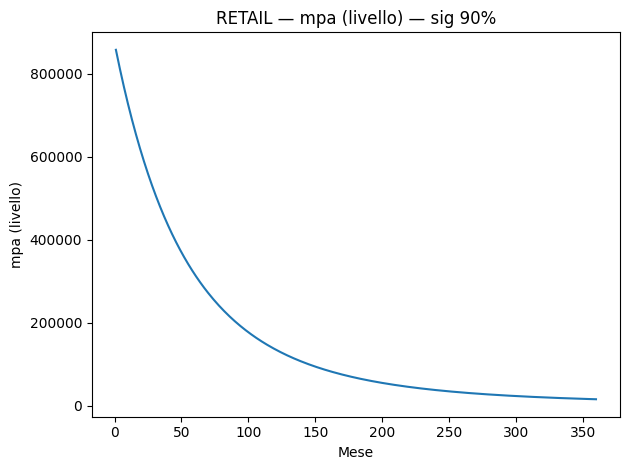


=== RETAIL — significance 95% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,880628.0,871994.369277,0.009804,0.95,0.996881,0.00018


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,mpa_livello
0,1,0.022905,0.022905,0.000017,0.022922,851823.866196
2,3,0.021724,0.066935,0.000017,0.021742,813049.634436
11,12,0.017183,0.238875,0.000017,0.017200,661634.158233
23,24,0.012681,0.414304,0.000017,0.012698,507146.705286
35,36,0.009451,0.544431,0.000017,0.009468,392553.121504
47,48,0.007110,0.641888,0.000017,0.007127,306729.859477


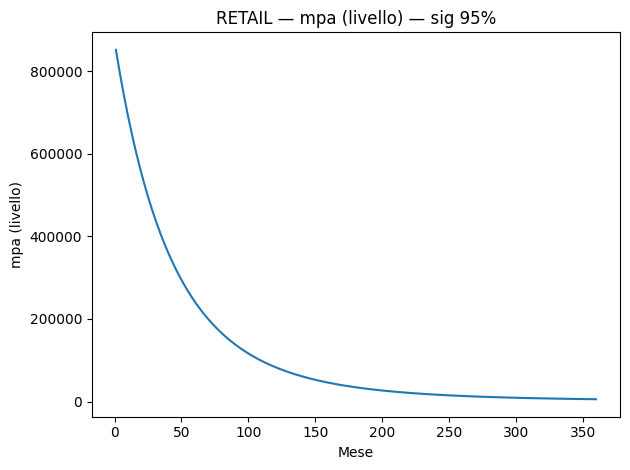


=== CORPORATE — significance 90% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,387071.0,372549.716061,0.037516,0.9,0.99654,0.000582


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,mpa_livello
0,1,0.031267,0.031267,0.000003,0.031270,360447.090472
2,3,0.029073,0.090489,0.000003,0.029076,337524.109165
11,12,0.021073,0.310077,0.000003,0.021076,252527.915153
23,24,0.013912,0.513198,0.000003,0.013915,173905.809418
35,36,0.009325,0.648341,0.000003,0.009328,121595.659317
47,48,0.006343,0.739609,0.000003,0.006346,86268.550357


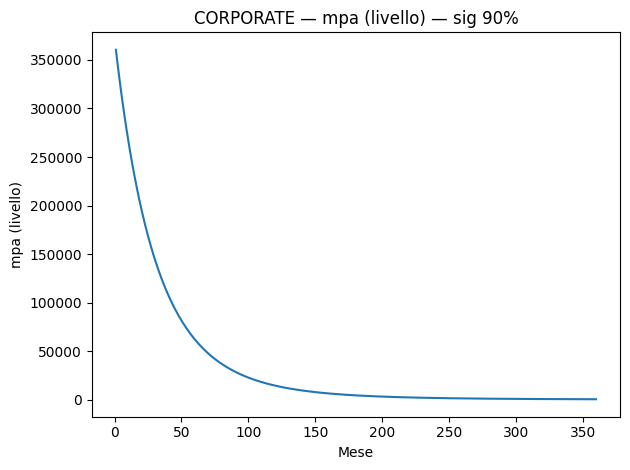


=== CORPORATE — significance 95% ===


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q
0,387071.0,370049.283358,0.043976,0.95,0.99654,0.000582


,h_mese,qc_pct,qc_pct_cum,residuale_uniforme_pct,ammortamento_pct,mpa_livello
0,1,0.039111,0.039111,4.860235e-07,0.039111,354910.620170
2,3,0.035738,0.112233,4.860235e-07,0.035738,326607.328893
11,12,0.023985,0.371400,4.860235e-07,0.023986,226291.233676
23,24,0.014343,0.591282,4.860235e-07,0.014343,141181.272482
35,36,0.008744,0.724049,4.860235e-07,0.008744,89791.078457
47,48,0.005429,0.805743,4.860235e-07,0.005430,58169.588635


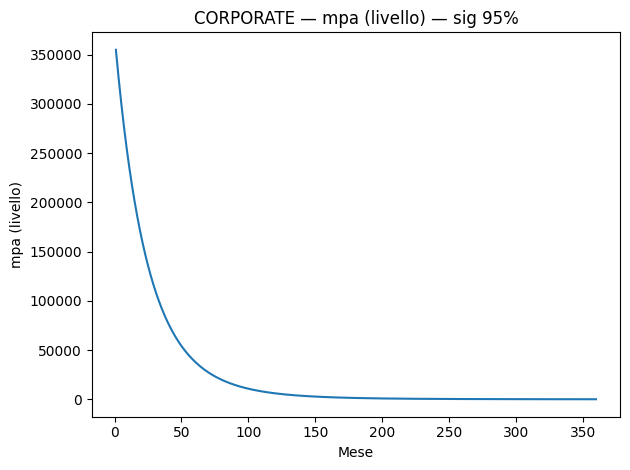

In [84]:
retail_step4 = run_step4_for("RETAIL", retail_step2, retail_res_exact)
corporate_step4 = run_step4_for("CORPORATE", corporate_step2, corporate_res_exact)

In [85]:


# Confronto rapido parametri
def compare_params(old, new, name):
    print(f"\n{name} — confronto parametri")
    for p in ["beta","Q","R"]:
        o = getattr(old.params, p); n = getattr(new.params, p)
        delta = (n - o)
        rel   = delta / (abs(o) + 1e-12)
        print(f"  {p:>4s}: old={o:.6g}  new={n:.6g}  Δ={delta:.3g}  rel={rel:.3%}")

compare_params(retail_res,   retail_res_exact,   "RETAIL")
compare_params(corporate_res,corporate_res_exact,"CORPORATE")



RETAIL — confronto parametri
  beta: old=0.996523  new=0.996881  Δ=0.000358  rel=0.036%
     Q: old=0.000245812  new=0.000179624  Δ=-6.62e-05  rel=-26.926%
     R: old=3.80991e-06  new=3.33689e-05  Δ=2.96e-05  rel=775.846%

CORPORATE — confronto parametri
  beta: old=0.993518  new=0.99654  Δ=0.00302  rel=0.304%
     Q: old=0.00165251  new=0.000582485  Δ=-0.00107  rel=-64.752%
     R: old=9.41626e-06  new=0.000547119  Δ=0.000538  rel=5710.366%


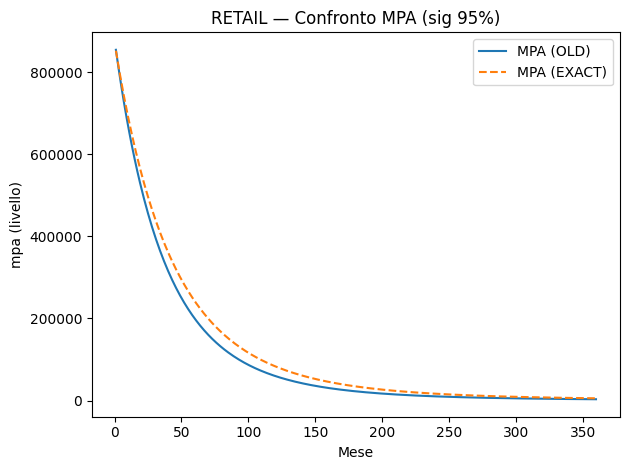

,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q,version
0,880628.0,877712.009471,0.003311,0.95,0.996523,0.000246,OLD


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q,version
0,880628.0,871994.369277,0.009804,0.95,0.996881,0.00018,EXACT


,h_mese,amm_old_pct,amm_exact_pct,delta_pct
0,1,0.026876,0.022922,-0.003954
1,2,0.026062,0.022323,-0.003739
2,3,0.025276,0.021742,-0.003534
3,4,0.024515,0.021177,-0.003338
4,5,0.023779,0.020628,-0.003151
5,6,0.023068,0.020095,-0.002973
6,7,0.022380,0.019577,-0.002803
7,8,0.021715,0.019074,-0.002640
8,9,0.021071,0.018585,-0.002486
9,10,0.020448,0.018110,-0.002338


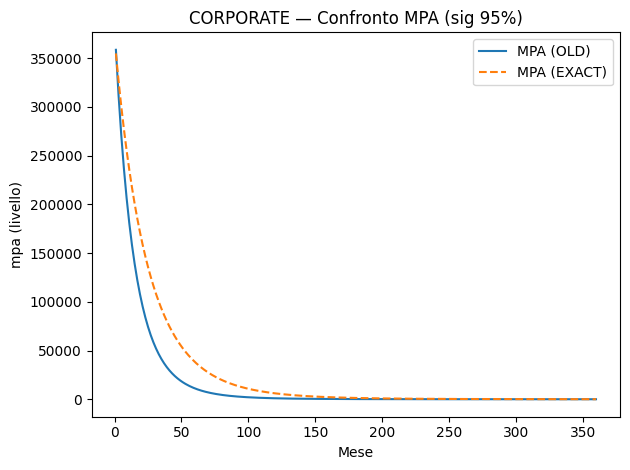

,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q,version
0,387071.0,385026.87641,0.005281,0.95,0.993518,0.001653,OLD


,VT_livello,stable_T_livello,quota_volatile_l_T,significance,beta,Q,version
0,387071.0,370049.283358,0.043976,0.95,0.99654,0.000582,EXACT


,h_mese,amm_old_pct,amm_exact_pct,delta_pct
0,1,0.068180,0.039111,-0.029069
1,2,0.063110,0.037384,-0.025726
2,3,0.058443,0.035738,-0.022705
3,4,0.054146,0.034170,-0.019976
4,5,0.050188,0.032675,-0.017513
5,6,0.046540,0.031250,-0.015290
6,7,0.043177,0.029892,-0.013285
7,8,0.040074,0.028596,-0.011478
8,9,0.037211,0.027361,-0.009850
9,10,0.034567,0.026182,-0.008385


In [86]:
# Confronto MPA/ammortamenti old vs exact per una sola significance (es. 95%)
import matplotlib.pyplot as plt
import pandas as pd

def compare_mpa(step2_df, res_old, res_new, name, sig=0.95, H=360):
    v_log = step2_df["v_log"].values.astype(float)

    # Calcolo profili con i due set di parametri
    sum_old, sch_old = stable_volatile_and_mpa(v_log, res_old.xs, res_old.Ps,
                                               res_old.params.beta, res_old.params.Q,
                                               horizons=H, significance=sig)
    sum_new, sch_new = stable_volatile_and_mpa(v_log, res_new.xs, res_new.Ps,
                                               res_new.params.beta, res_new.params.Q,
                                               horizons=H, significance=sig)

    # Grafico MPA (livello)
    plt.figure()
    plt.plot(sch_old["h_mese"], sch_old["mpa_livello"], label="MPA (OLD)")
    plt.plot(sch_new["h_mese"], sch_new["mpa_livello"], label="MPA (EXACT)", linestyle="--")
    plt.title(f"{name} — Confronto MPA (sig {int(sig*100)}%)")
    plt.xlabel("Mese"); plt.ylabel("mpa (livello)"); plt.legend()
    plt.tight_layout(); plt.show()

    # Tabelle sintetiche (summary) e primi 12 mesi di ammortamento
    display(sum_old.assign(version="OLD"))
    display(sum_new.assign(version="EXACT"))
    head_cmp = pd.DataFrame({
        "h_mese": sch_old["h_mese"].head(12),
        "amm_old_pct": sch_old["ammortamento_pct"].head(12),
        "amm_exact_pct": sch_new["ammortamento_pct"].head(12),
        "delta_pct": (sch_new["ammortamento_pct"] - sch_old["ammortamento_pct"]).head(12),
    })
    display(head_cmp)

# Esempi di confronto
compare_mpa(retail_step2,    retail_res,    retail_res_exact,    "RETAIL",    sig=0.95, H=HOLDING_PERIOD)
compare_mpa(corporate_step2, corporate_res, corporate_res_exact, "CORPORATE", sig=0.95, H=HOLDING_PERIOD)
